# Barangay CENTROID EXTRACTION 
### Introduction: Barangay Centroid Coordinates of Iligan City



# Iligan City Spatial Data Preparation  
*Centroid Extraction and Road Network Construction*

This notebook documents the steps taken to extract accurate geographic and network features of Iligan City for spatial analysis and emergency response planning.

## Objective

To prepare clean, GIS-ready spatial datasets that include:

- Centroids of all 44 barangays in Iligan City  
- A complete road network graph suitable for distance and travel time computations

These data layers will support downstream applications such as facility location optimization, response time analysis, and service accessibility modeling.

---

##  Part 1: Barangay Centroid Extraction

Barangay boundaries are sourced from **OpenStreetMap (OSM)** using `osmnx` and `geopandas`. Only polygons tagged with `admin_level=10` (the OSM convention for barangay-level units) were considered. Steps include:

- Defining a bounding box that encloses Iligan City
- Querying administrative boundaries from OSM
- Converting polygon geometries to geometric centroids
- Reprojecting results to WGS 84 (`EPSG:4326`)
- Aligning extracted centroids with a trusted list of 44 barangays for consistency

Each barangay is flagged as `FOUND` or `NOT FOUND` based on whether a centroid match was detected from OSM.

---

##  Part 2: Road Network Construction

Using `osmnx`, we extract a drivable road network within a bounding box that encompasses the entire city. The procedure involves:

- Defining the full extent of Iligan City using a manually verified bounding box
- Downloading the road graph (`network_type='drive'`)
- Converting the graph to GeoDataFrames for nodes and edges
- Saving the shapefiles for use in GIS software or routing algorithms

This road network will later support shortest-path calculations (e.g., Dijkstra’s algorithm) to estimate actual travel distance or time between fire stations and barangays.

---

The outputs of this notebook are foundational to the broader research objective: optimizing fire response coverage across Iligan City using real-world geographic and demographic data.


In [13]:
import pandas as pd
import geopandas as gpd
from osmnx.features import features_from_polygon
from shapely.geometry import box

# Step 1: Trusted Iligan barangay names (alphabetical order)
iligan_names = [
    "Abuno", "Acmac", "Bagong Silang", "Bonbonon", "Bunawan", "Buru-un", "Dalipuga", "Del Carmen",
    "Digkilaan", "Ditucalan", "Dulag", "Hinaplanon", "Hindang", "Kabacsanan", "Kalilangan", "Kiwalan",
    "Lanipao", "Luinab", "Mahayahay", "Mainit", "Mandulog", "Maria Cristina", "Pala-o", "Palaopao",
    "Poblacion", "Rogongon", "San Miguel", "San Roque", "Santa Elena", "Santa Filomena", "Santa Maria",
    "Santiago", "Saray-Timbo", "Suarez", "Tambacan", "Tibanga", "Tipanoy", "Tomas Cabili", "Tubon",
    "Tugaya", "Upper Hinaplanon", "Ubaldo Laya", "Villaverde"
]

# Step 2: Define bounding box and fetch OSM data
bbox_polygon = box(124.1780332, 8.146600772, 124.5197515, 8.315802406)
osm_raw = features_from_polygon(bbox_polygon, tags={"boundary": "administrative", "admin_level": "10"})
osm_gdf = osm_raw.reset_index()[["name", "geometry"]].dropna()
osm_gdf["name"] = osm_gdf["name"].str.strip()

# Step 3: Compute accurate centroids
osm_proj = osm_gdf.to_crs(epsg=32651)
osm_proj["geometry"] = osm_proj.geometry.centroid
osm_gdf = osm_proj.to_crs(epsg=4326)

# Step 4: Build aligned rows in your original order
rows = []
for barangay in iligan_names:
    match = osm_gdf[osm_gdf["name"] == barangay]
    if not match.empty:
        lon, lat = match.iloc[0].geometry.x, match.iloc[0].geometry.y
        rows.append({
            "Barangay": barangay,
            "Latitude": lat,
            "Longitude": lon,
            "Match_Status": "FOUND"
        })
    else:
        rows.append({
            "Barangay": barangay,
            "Latitude": "NOT FOUND",
            "Longitude": "NOT FOUND",
            "Match_Status": "NOT FOUND"
        })

# Step 5: Create and save DataFrame in correct order
df = pd.DataFrame(rows)
output_path = "barangay_centroids_output/iligan_centroids_with_status.csv"
df.to_csv(output_path, index=False)

print(f"Saved ordered CSV with 44 barangays to {output_path}")


Saved ordered CSV with 44 barangays to barangay_centroids_output/iligan_centroids_with_status.csv


In [15]:
import os

output_dir = "barangay_centroids_output"
if os.path.exists(output_dir):
    print(f" Found folder: {output_dir}")
    print(" Files inside:")
    print(os.listdir(output_dir))
else:
    print(" Folder not found!")


 Found folder: barangay_centroids_output
 Files inside:
['.ipynb_checkpoints', 'barangay_centroids_osm_bbox.csv', 'barangay_centroids_osm_bbox.geojson', 'barangay_centroids_osm_iligan_only.csv', 'barangay_centroids_osm_iligan_only.geojson', 'iligan_centroids_with_status.csv']


## Checking for Mismatched Names

In [19]:
# Diagnostic: Print which expected barangays were NOT matched
found = set(osm_gdf["name"])
expected = set(iligan_names)
missing = expected - found

print(f"Missing ({len(missing)}):", sorted(missing))



Missing (8): ['Buru-un', 'Palaopao', 'Santa Maria', 'Saray-Timbo', 'Tomas Cabili', 'Tubon', 'Tugaya', 'Villaverde']


In [23]:
from difflib import get_close_matches

# Trusted list
iligan_names = [
    "Abuno", "Acmac", "Bagong Silang", "Bonbonon", "Bunawan", "Buru-un", "Dalipuga", "Del Carmen",
    "Digkilaan", "Ditucalan", "Dulag", "Hinaplanon", "Hindang", "Kabacsanan", "Kalilangan", "Kiwalan",
    "Lanipao", "Luinab", "Mahayahay", "Mainit", "Mandulog", "Maria Cristina", "Pala-o", "Palaopao",
    "Poblacion", "Rogongon", "San Miguel", "San Roque", "Santa Elena", "Santa Filomena", "Santa Maria",
    "Santiago", "Saray-Timbo", "Suarez", "Tambacan", "Tibanga", "Tipanoy", "Tomas Cabili", "Tubon",
    "Tugaya", "Upper Hinaplanon", "Ubaldo Laya", "Villaverde"
]

# Extract matched names
matched_names = set(osm_gdf["name"])
expected_names = set(iligan_names)

# Find missing ones
missing = expected_names - matched_names
print(f"Missing ({len(missing)}):", sorted(missing))

# Print closest OSM matches for each missing barangay
print("\nClosest matches in OSM for missing barangays:")
osm_names = sorted(osm_gdf["name"].unique())
for name in sorted(missing):
    suggestion = get_close_matches(name, osm_names, n=1, cutoff=0.6)
    suggestion = suggestion[0] if suggestion else "No close match"
    print(f"  {name:<20} → {suggestion}")



Missing (8): ['Buru-un', 'Palaopao', 'Santa Maria', 'Saray-Timbo', 'Tomas Cabili', 'Tubon', 'Tugaya', 'Villaverde']

Closest matches in OSM for missing barangays:
  Buru-un              → No close match
  Palaopao             → Pala-o
  Santa Maria          → Santo Rosario
  Saray-Timbo          → Saray
  Tomas Cabili         → Tomas L. Cabili
  Tubon                → Tubod
  Tugaya               → Puga-an
  Villaverde           → Villa Verde


In [25]:
# Strip whitespace from OSM names just in case
osm_gdf["name"] = osm_gdf["name"].str.strip()

# Define your trusted list of 44 Iligan barangays
iligan_names = [
    "Abuno", "Acmac", "Bagong Silang", "Bonbonon", "Bunawan", "Buru-un", "Dalipuga", "Del Carmen",
    "Digkilaan", "Ditucalan", "Dulag", "Hinaplanon", "Hindang", "Kabacsanan", "Kalilangan", "Kiwalan",
    "Lanipao", "Luinab", "Mahayahay", "Mainit", "Mandulog", "Maria Cristina", "Pala-o", "Palaopao",
    "Poblacion", "Rogongon", "San Miguel", "San Roque", "Santa Elena", "Santa Filomena", "Santa Maria",
    "Santiago", "Saray-Timbo", "Suarez", "Tambacan", "Tibanga", "Tipanoy", "Tomas Cabili", "Tubon",
    "Tugaya", "Upper Hinaplanon", "Ubaldo Laya", "Villaverde"
]

# Check which of the 44 names are missing from the OSM data
osm_names = set(osm_gdf["name"])
missing_from_osm = [name for name in iligan_names if name not in osm_names]

# Print the result
print(f" The following {len(missing_from_osm)} barangays from your trusted list were NOT found in OSM:")
for name in missing_from_osm:
    print(f"  - {name}")


 The following 8 barangays from your trusted list were NOT found in OSM:
  - Buru-un
  - Palaopao
  - Santa Maria
  - Saray-Timbo
  - Tomas Cabili
  - Tubon
  - Tugaya
  - Villaverde


These 8 barangays were then manually replaced values through googlmaps estimate coordinates saved in file merged_barangay_centroids_44.csv

# Coordinates to Box FULL ILIGAN Maximum with respect to Barangay Centroids

In [32]:
import pandas as pd
from shapely.geometry import box
import gdown


# Direct download URL using the file ID from Google Drive
file_id = "1AiVGbwrStc6LydSYJgeq-xQWGasDhtCz"
url = f"https://drive.google.com/uc?id={file_id}"

# Download the file from Google Drive
output_file = "merged_barangay_centroids_44.csv"
gdown.download(url, output_file, quiet=False)

# Load the CSV file
df = pd.read_csv(output_file)

# Preview the data
df.head()

# Automatically compute bounds
north = df["Latitude"].max()
south = df["Latitude"].min()
east = df["Longitude"].max()
west = df["Longitude"].min()

# Build bounding box polygon (Shapely expects west, south, east, north)
bbox_polygon = box(west, south, east, north)

# Print for reference
#print(f"bbox_polygon = box(west, south, east, north)")
print(f"bbox_polygon = box({west}, {south}, {east}, {north})")



Downloading...
From: https://drive.google.com/uc?id=1AiVGbwrStc6LydSYJgeq-xQWGasDhtCz
To: C:\Users\ELGIE\merged_barangay_centroids_44.csv
100%|██████████████████████████████████████████████████████████████████████████████| 1.55k/1.55k [00:00<00:00, 478kB/s]

bbox_polygon = box(124.1780332, 8.146600772, 124.5197515, 8.315802406)


# FINAL BOX Considering Coordinates outside Iligan From 4 Directions

Minor values are made to properly box iligan.

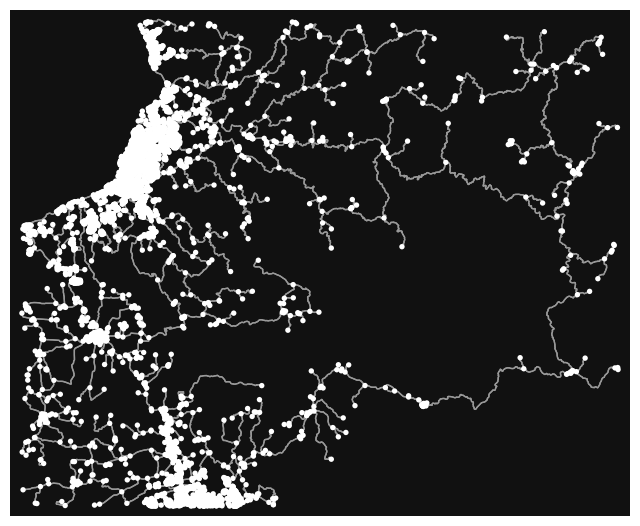

C:\Users\ELGIE\AppData\Local\Temp\ipykernel_11676\1908798830.py:21: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nodes.to_file(f"{output_dir}/nodes.shp")
C:\Users\ELGIE\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'street_count' to 'street_cou'
  ogr_write(


 Full Iligan road network saved to folder: full_iligan_roads_buffer


In [40]:
import os
import osmnx as ox
from shapely.geometry import box

# Step 1: Define bounding box that fully covers Iligan City
bbox_polygon = box(124.1680332, 8.001, 124.57, 8.324)  # west, south, east, north

# Step 2: Download complete road network inside bounding box
G = ox.graph_from_polygon(bbox_polygon, network_type='drive')

# Step 3: Plot to confirm visual coverage
ox.plot_graph(G)

# Step 4: Convert to GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G)

#  Step 5: Save into a new output folder
output_dir = "full_iligan_roads_buffer"
os.makedirs(output_dir, exist_ok=True)

nodes.to_file(f"{output_dir}/nodes.shp")
edges.to_file(f"{output_dir}/edges.shp")

print(f" Full Iligan road network saved to folder: {output_dir}")
